In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import signal
from scipy import interpolate
from scipy.odr import Model, RealData, ODR

from dateutil import parser

anem_str2date = lambda x: parser.parse(x.decode("utf-8"))
flight_str2data = lambda x: parser.parse(x.decode("utf-8"))

from local_utils import *

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

def lin_fit(coeffs, x):
    return coeffs[0]*x + coeffs[1]

def lin_fit_with_zero_intercept(coeffs, x):
    # Forcing a zero intercept fit
    return coeffs[0]*x

/var/folders/gh/h5y326mn4jn844lcv0wlxs9c0000gp/T/ipykernel_2791/444368055.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  flight_data = np.genfromtxt(flight_filename, dtype=None, delimiter=',', names=True,
/var/folders/gh/h5y326mn4jn844lcv0wlxs9c0000gp/T/ipykernel_2791/444368055.py:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  anem_data = np.genfromtxt(anem_data_filename, dtype=None, names=True, delimiter=',',


0:00:00.100000
np.std:  0.2240831579193265
Beta: [1.04132987]
Beta Std Error: [0.00978074]
Beta Covariance: [[2.45351503e-05]]
Residual Variance: 3.8990136301917064
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


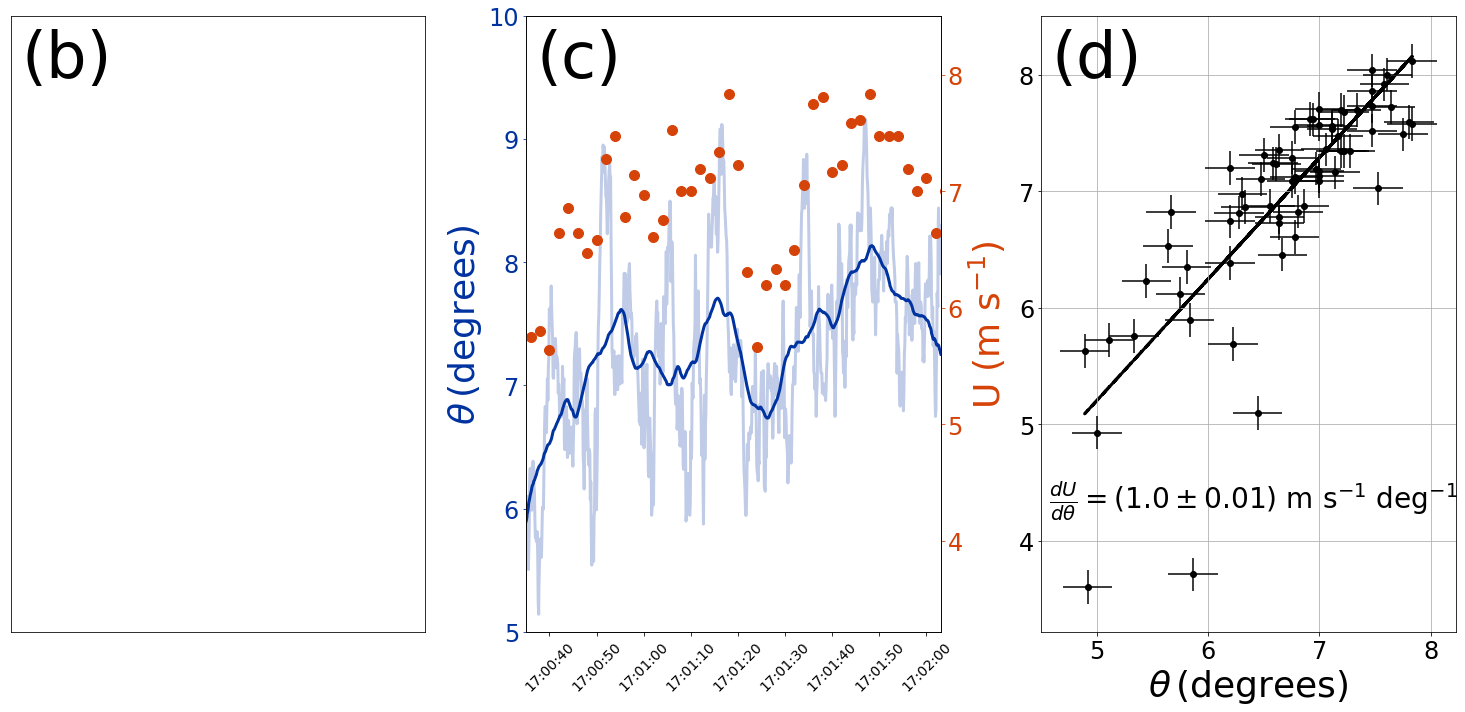

In [7]:
# First flight at Seal Beach
flight_filename ="Field_Experiments/Drone_Experiments/2022-06-08_17-00-17_v2 - only hover.csv"
flight_data = np.genfromtxt(flight_filename, dtype=None, delimiter=',', names=True, 
                           converters = {"datetimelocal": flight_str2data})

anem_data_filename = "Field_Experiments/Drone_Experiments/WEATHER_-_2636851_Jun_8_2022_8_42_46_PM.csv"
anem_data = np.genfromtxt(anem_data_filename, dtype=None, names=True, delimiter=',', 
                          converters = {"FORMATTED_DATE_TIME": anem_str2date})

# Convert from km/hr to m/s
anem_data["Wind_Speed"] *= 0.277778

# For some reason, the anemometer doesn't record seconds. 
# Since the data are collected at 0.5 Hz, we can reconstruct the seconds.
# print(datetime("2022-06-08 17:00:45"))

# Because of the way the time conversion for the anemometers works, I have to have two separate times
min_time = datetime(2022, 6, 8, 17, 0, 0)
max_time = datetime(2022, 6, 8, 17, 2, 5)

min_plot_time = datetime(2022, 6, 8, 17, 0, 35)
max_plot_time = datetime(2022, 6, 8, 17, 2, 3)

# print(flight_data['datetimelocal'])

anem_ind = (anem_data["FORMATTED_DATE_TIME"] >= min_time) &\
        (anem_data["FORMATTED_DATE_TIME"] <= max_time)
anem_times = np.arange(np.min(anem_data["FORMATTED_DATE_TIME"][anem_ind]), 
                       np.max(anem_data["FORMATTED_DATE_TIME"][anem_ind]) + timedelta(minutes=1), 
                       timedelta(seconds=2)).astype(datetime)

tilt = calc_tilt(flight_data['pitchdeg'], flight_data['rolldeg'])

N = 100 # measurements every 0.1 of a second
filtered_tilt = np.convolve(tilt, np.ones(N)/N, mode='same')

fig = plt.figure(figsize=(12*aspect_ratio, 10))
ax1 = fig.add_subplot(132)
ax2 = ax1.twinx()
ax3 = fig.add_subplot(133, sharey=ax2)

# For the photograph - empty out the axis labels
ax4 = fig.add_subplot(131)
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

ax4.text(0.025, 0.9, "(b)", fontsize=64, transform=ax4.transAxes)

# plt.scatter(flight_data['datetimelocal'], filtered_tilt)

# These actually match up pretty well!
ax1.plot(flight_data['datetimelocal'], tilt, lw=3, color=BoiseState_blue, alpha=0.25)

print(np.median(flight_data['datetimelocal'][1:] - flight_data['datetimelocal'][:-1]))

# ax1.plot(flight_data['datetimelocal'], flight_data['yawdeg'], lw=3, color='green')
ax1.plot(flight_data['datetimelocal'], filtered_tilt, lw=3, color=BoiseState_blue)
ax2.scatter(anem_times, anem_data["Wind_Speed"][anem_ind], color=BoiseState_orange, s=100)

# Estimating the point-to-point scatter
print("np.std: ", np.std(np.abs(anem_data["Wind_Speed"][1:] - anem_data["Wind_Speed"][:-1])))

ax1.set_ylabel(r'$\theta\, \left( {\rm degrees} \right)$', fontsize=36, color=BoiseState_blue)
ax2.set_ylabel(r'U (${\rm m\ s^{-1}}$)', fontsize=36, color=BoiseState_orange)
ax2.tick_params(axis='y', colors=BoiseState_orange, labelsize=24)
ax1.tick_params(axis='y', colors=BoiseState_blue)
ax1.tick_params(axis='x', labelsize=14)
for label in ax1.get_xticklabels():
  label.set_rotation(45)
ax1.tick_params(axis='y', labelsize=24)
ax2.text(0.025, 0.9, "(c)", fontsize=64, transform=ax1.transAxes)

### Interpolated Tilt ####

# Convert times to float array
flight_time_delta =\
    np.array([(flight_data['datetimelocal'][i] - flight_data['datetimelocal'][0]).seconds +\
              (flight_data['datetimelocal'][i] - flight_data['datetimelocal'][0]).microseconds/1e6
              for i in range(len(flight_data['datetimelocal']))])
anem_time_delta = \
    np.array([(anem_times[i] - flight_data['datetimelocal'][0]).seconds +\
              (anem_times[i] - flight_data['datetimelocal'][0]).microseconds/1e6
              for i in range(len(anem_times))])

# For some reason, python thinks these time stamps are one day apart...
# print(flight_data['datetimelocal'][0], anem_times[0], (anem_times[0] - flight_data['datetimelocal'][0]))

# Interpolate flight data to anemometer times
interpolated_filtered_tilt = np.interp(anem_time_delta, flight_time_delta, filtered_tilt)

x = anem_data["Wind_Speed"][anem_ind]
y = interpolated_filtered_tilt

# Interpolation goofs up beyond this because there are no tilt points
oind = anem_time_delta < 134
x = x[oind]
y = y[oind]

# estimate uncertainties using point-to-point difference
x_sigma = np.median(np.abs(x[1:] - x[:-1]))
y_sigma = np.median(np.abs(y[1:] - y[:-1]))

# linear = Model(lin_fit)
linear = Model(lin_fit_with_zero_intercept)
mydata = RealData(x, y, sx=x_sigma, sy=y_sigma)
# myodr = ODR(mydata, linear, beta0=[1., 2.])
myodr = ODR(mydata, linear, beta0=[1.])
myoutput = myodr.run()

# odr appears to re-scale uncertainties based on reduced chi-squared!
myoutput.pprint()

# popt, pcov = curve_fit(lin_fit, x, y)
# unc = np.sqrt()
# ax3.scatter(x, y, marker='o', s=100, color='k')
ax3.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='o', ls='', color='k')
# ax3.plot(x, np.polyval(myoutput.beta, x), lw=3, ls='--', color='k', zorder=-1)
ax3.plot(x, lin_fit_with_zero_intercept(myoutput.beta, x), lw=3, ls='--', color='k', zorder=-1)

# ax3.yaxis.tick_right()
# ax3.yaxis.set_label_position("right")
ax3.set_xlabel(r'$\theta\, \left( {\rm degrees} \right)$', fontsize=36)
ax3.tick_params(labelsize=24)
ax3.grid(True)
ax3.text(0.025, 0.9, "(d)", fontsize=64, transform=ax3.transAxes)
ax3.text(0.02, 0.2,
         r'$\frac{dU}{d\theta} = \left( %.1f\pm%.2f \right)\ {\rm m\ s^{-1}\ deg^{-1}} $' %\
         (myoutput.beta[0], myoutput.sd_beta[0]), fontsize=28, transform=ax3.transAxes)

# ax3.text(0.2, 0.18,
#          r'$U_0 = \left( %.1f\pm%.1f \right)\ {\rm m\ s^{-1}} $' %\
#          (myoutput.beta[1], myoutput.sd_beta[1]), fontsize=24, transform=ax3.transAxes)

# plt.xlim([20000, 100000])
ax1.set_xlim([min_plot_time, max_plot_time])
ax1.set_ylim([5, 10])

plt.tight_layout()

fig.savefig("example_tilt_and_windspeed_just-d.jpg", dpi=300, bbox_inches='tight')

In [ ]:
flight_filename ="Field_Experiments/Drone_Experiments/2022-06-08_17-40-07_v2 - profile.csv"
flight_data = np.genfromtxt(flight_filename, dtype=None, delimiter=',', names=True, 
                           converters = {"datetimelocal": flight_str2data})

# anem_data_filename = "Field_Experiments/Drone_Experiments/WEATHER_-_2636851_Jun_8_2022_8_42_46_PM.csv"
# anem_data = np.genfromtxt(anem_data_filename, dtype=None, names=True, delimiter=',', 
#                           converters = {"FORMATTED_DATE_TIME": anem_str2date})

# Convert from km/hr to m/s
# anem_data["Wind_Speed"] *= 0.277778

# For some reason, the anemometer doesn't record seconds. 
# Since the data are collected at 0.5 Hz, we can reconstruct the seconds.
# print(datetime("2022-06-08 17:00:45"))

# Because of the way the time conversion for the anemometers works, I have to have two separate times
min_time = datetime(2022, 6, 8, 17, 0, 0)
max_time = datetime(2022, 6, 8, 17, 2, 5)

min_plot_time = datetime(2022, 6, 8, 17, 0, 35)
max_plot_time = datetime(2022, 6, 8, 17, 2, 3)

# print(flight_data['datetimelocal'])

# anem_ind = (anem_data["FORMATTED_DATE_TIME"] >= min_time) &\
#         (anem_data["FORMATTED_DATE_TIME"] <= max_time)
# anem_times = np.arange(np.min(anem_data["FORMATTED_DATE_TIME"][anem_ind]), 
#                        np.max(anem_data["FORMATTED_DATE_TIME"][anem_ind]) + timedelta(minutes=1), 
#                        timedelta(seconds=2)).astype(datetime)

# tilt = calc_tilt(flight_data['pitchdeg'], flight_data['rolldeg'])

# N = 100 # measurements every 0.1 of a second
# filtered_tilt = np.convolve(tilt, np.ones(N)/N, mode='same')